In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Configurazione stile grafici
plt.style.use('seaborn-v0_8')

# 1. Caricamento del dataset
df = pd.read_csv('data/puliti/movimento_fe.csv')

print(f"Dataset caricato: {df.shape[0]} giocatori totali.")

Dataset caricato: 15738 giocatori totali.


In [3]:
# 1. Selezione delle colonne numeriche
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Lista di colonne da ESCLUDERE (non sono abilità tecniche)
# Nota: Escludiamo 'OVR' dalle feature di training perché lo usiamo come filtro dopo!
cols_to_exclude = [
    'ID', 'Jersey Number', 'Age', 'OVR', 'Potential', 'Special', 
    'International Reputation', 'Weak Foot', 'Skill Moves', 'Kit Number'
]
features_to_use = [col for col in numeric_cols if col not in cols_to_exclude]

# Creiamo il dataset X pulito (gestione valori mancanti con la media)
X_all = df[features_to_use].fillna(df[features_to_use].mean())

# 2. Rimozione Feature Ridondanti (Correlazione > 90%)
corr_matrix = X_all.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Troviamo le colonne troppo simili (es. Acceleration vs Sprint Speed)
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

print(f"Feature iniziali: {len(features_to_use)}")
print(f"Feature rimosse per ridondanza: {len(to_drop)}")
print(f"Esempio rimosse: {to_drop[:3]}...")

# Lista finale delle feature utili
final_features = [f for f in features_to_use if f not in to_drop]

Feature iniziali: 50
Feature rimosse per ridondanza: 11
Esempio rimosse: ['Acceleration', 'Sprint Speed', 'Finishing']...


In [4]:
# Imposta la soglia (es. 75 = Giocatori Oro/Top)
soglia_ovr = 75

# Creiamo il sotto-dataset
df_top = df[df['OVR'] >= soglia_ovr].copy()
X_top = df_top[final_features].fillna(df_top[final_features].mean())

print(f"--- FILTRO APPLICATO (OVR >= {soglia_ovr}) ---")
print(f"Giocatori analizzati: {len(df_top)} (su {len(df)} totali)")

--- FILTRO APPLICATO (OVR >= 75) ---
Giocatori analizzati: 2086 (su 15738 totali)


In [5]:
# 1. Standardizzazione (Scaling)
scaler = StandardScaler()
X_top_scaled = scaler.fit_transform(X_top)

# 2. PCA a 3 Componenti
pca = PCA(n_components=3)
X_top_pca = pca.fit_transform(X_top_scaled)

# Creiamo un DataFrame per comodità grafica
pca_df = pd.DataFrame(data=X_top_pca, columns=['PC1', 'PC2', 'PC3'])

print(f"Varianza spiegata dalle 3 componenti: {sum(pca.explained_variance_ratio_)*100:.2f}%")

Varianza spiegata dalle 3 componenti: 49.25%


Calcolo in corso per Gomito e Silhouette...


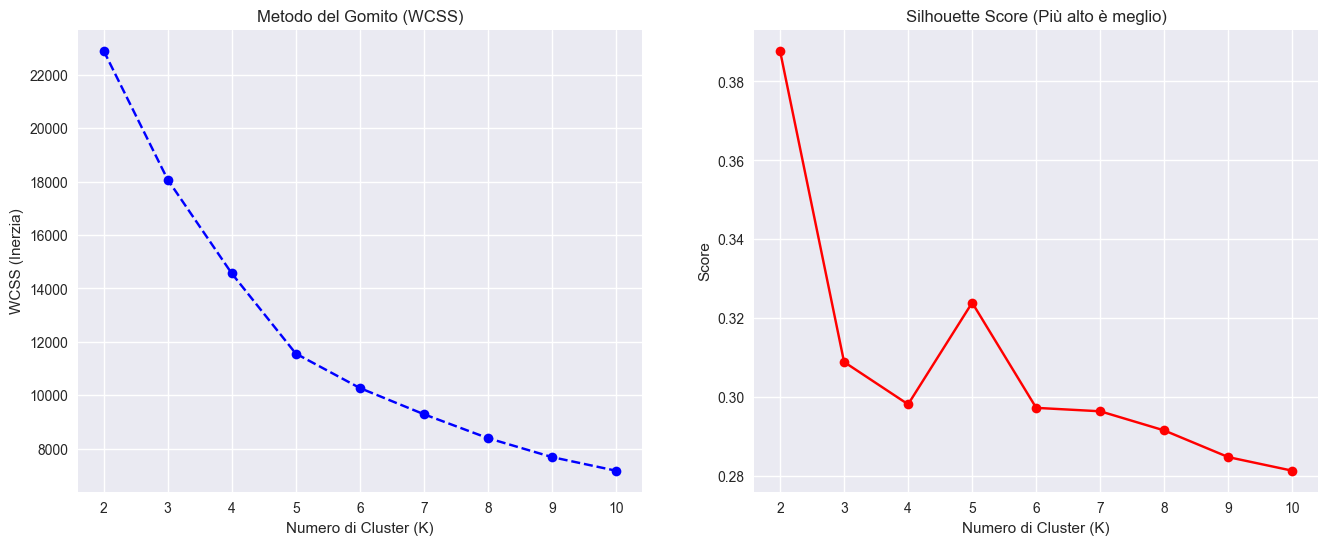

In [6]:
from sklearn.metrics import silhouette_score

# Liste per salvare i risultati
wcss = []
sil_scores = []
K_range = range(2, 11)  # Testiamo da 2 a 10 cluster

print("Calcolo in corso per Gomito e Silhouette...")

for k in K_range:
    # Eseguiamo K-Means su X_top_pca (i dati ridotti dei Top Players)
    kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_test.fit(X_top_pca)
    
    # Salviamo WCSS (Inerzia) e Silhouette
    wcss.append(kmeans_test.inertia_)
    sil_scores.append(silhouette_score(X_top_pca, kmeans_test.labels_))

# --- Creazione dei Grafici ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 1. Grafico del Gomito
ax1.plot(K_range, wcss, marker='o', linestyle='--', color='b')
ax1.set_title('Metodo del Gomito (WCSS)')
ax1.set_xlabel('Numero di Cluster (K)')
ax1.set_ylabel('WCSS (Inerzia)')
ax1.grid(True)

# 2. Grafico della Silhouette
ax2.plot(K_range, sil_scores, marker='o', linestyle='-', color='r')
ax2.set_title('Silhouette Score (Più alto è meglio)')
ax2.set_xlabel('Numero di Cluster (K)')
ax2.set_ylabel('Score')
ax2.grid(True)

plt.show()

In [7]:
# K-Means con 3 Cluster
kmeans3 = KMeans(n_clusters=3, random_state=42, n_init=10)
df_top['Cluster_3'] = kmeans3.fit_predict(X_top_pca)

# K-Means con 4 Cluster
kmeans4 = KMeans(n_clusters=4, random_state=42, n_init=10)
df_top['Cluster_4'] = kmeans4.fit_predict(X_top_pca)

print("Clustering completato.")

Clustering completato.


In [8]:
print("\n--- ANALISI TATTICA: CHI C'È NEI GRUPPI? ---")

print("\n>>> Configurazione a 3 CLUSTER (Difesa vs Centrocampo vs Attacco)")
print(pd.crosstab(df_top['Cluster_3'], df_top['Position']))

print("\n>>> Configurazione a 4 CLUSTER (Dettaglio su Terzini/Mediani)")
print(pd.crosstab(df_top['Cluster_4'], df_top['Position']))


--- ANALISI TATTICA: CHI C'È NEI GRUPPI? ---

>>> Configurazione a 3 CLUSTER (Difesa vs Centrocampo vs Attacco)
Position   CAM   CB  CDM   CM  LB   LM  LW  RB  RM  RW   ST
Cluster_3                                                  
0           85   31  146  269  81   21  21  66  23  18   45
1            0  389   61   12  45    0   0  77   0   0    8
2           75    0    1   12  12  102  49  16  99  59  263

>>> Configurazione a 4 CLUSTER (Dettaglio su Terzini/Mediani)
Position   CAM   CB  CDM   CM  LB  LM  LW   RB  RM  RW   ST
Cluster_4                                                  
0           68    0    0   15   2  94  41    7  89  50  250
1            0  321   10    0  17   0   0   23   0   0    5
2           88    4   42  161  20  27  29   17  26  26   59
3            4   95  156  117  99   2   0  112   7   1    2


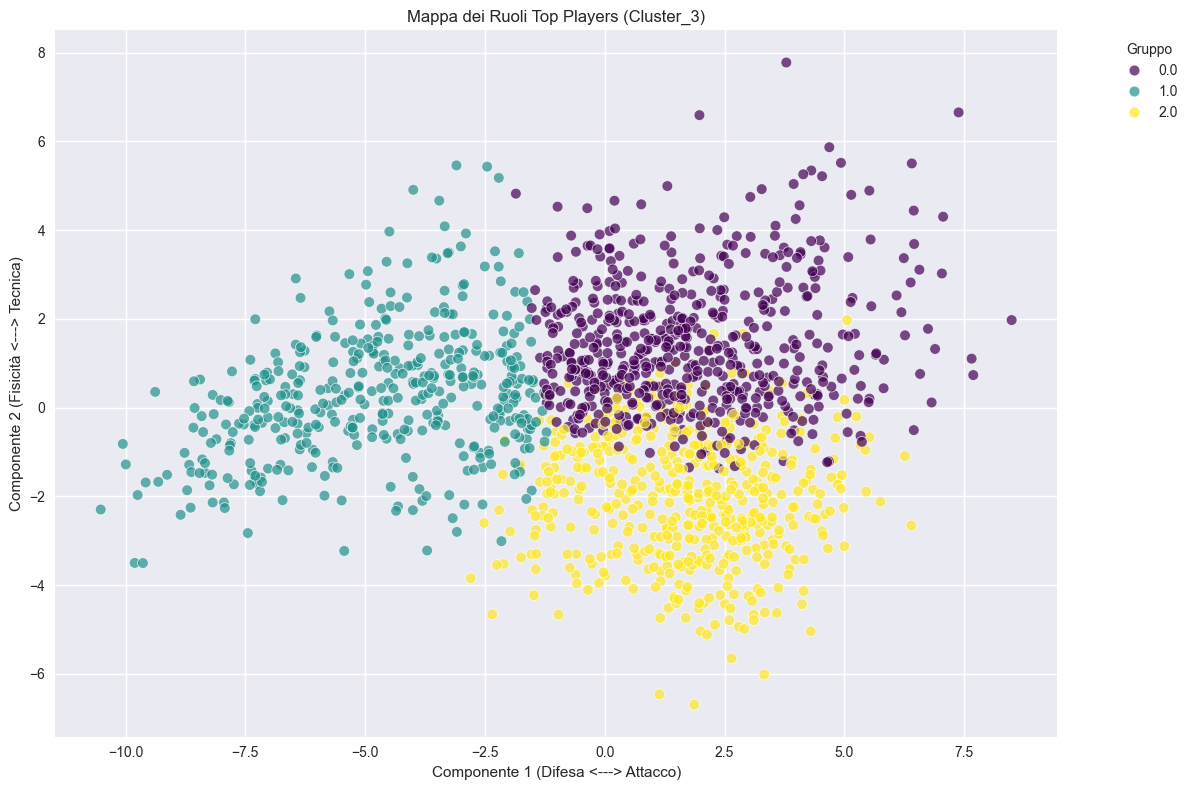

In [9]:
plt.figure(figsize=(12, 8))

# Scegli quale cluster visualizzare (Cluster_3 o Cluster_4)
cluster_da_visualizzare = 'Cluster_3' 

sns.scatterplot(
    x=pca_df['PC1'], 
    y=pca_df['PC2'], 
    hue=df_top[cluster_da_visualizzare], 
    palette='viridis', 
    alpha=0.7, 
    s=60
)

plt.title(f'Mappa dei Ruoli Top Players ({cluster_da_visualizzare})')
plt.xlabel('Componente 1 (Difesa <---> Attacco)')
plt.ylabel('Componente 2 (Fisicità <---> Tecnica)')
plt.legend(title='Gruppo', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()